In [1]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torchvision import datasets, transforms

Files already downloaded and verified
2
torch.Size([16, 3, 32, 32])
torch.Size([16])
tensor(8)


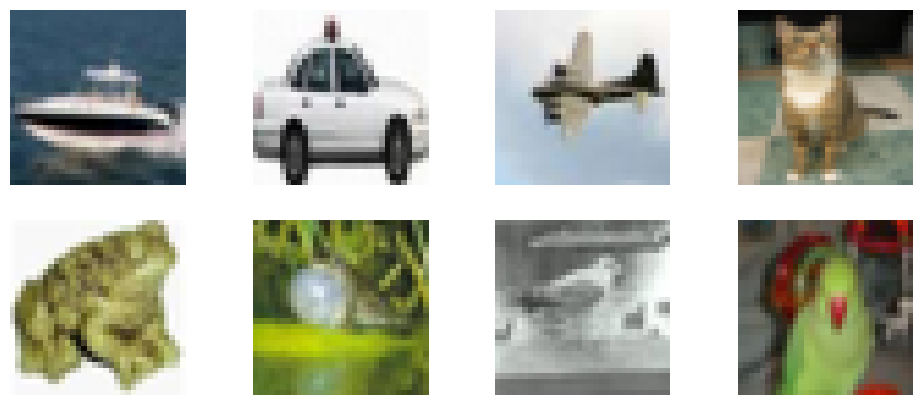

In [2]:
bs = 16
device='cuda'

dataloader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data/', train=True, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                  ])
                 ),
    batch_size=bs, shuffle=True
)

# 시각화
def visualize(img, epoch=0):
    if img.shape[0] == 1:
        plt.figure(figsize=(2,2))
        img = img.squeeze().permute(1,2,0)
        plt.imshow(img)
        plt.show()
    elif img.shape[0]>1 and len(img.shape)>2:
        fig, axes = plt.subplots(2, 4, figsize=(12, 5))
        for i, ax in enumerate(axes.flat):
            ax.imshow(img[i].squeeze().permute(1,2,0))
            ax.axis('off')
        # plt.savefig(f'{output_path}/valid_{epoch}.png')
        plt.show()

# 데이터 체크
data = next(iter(dataloader))
print(len(data))
print(data[0].shape)
print(data[1].shape)
print(data[1][0])

visualize(data[0])

In [3]:
class Block(nn.Module):
    """
    conv -> bn -> time embedding add -> activation
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(Block, self).__init__()
        self.conv=nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=kernel_size, stride=stride, padding=padding
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.0)

    def forward(self, x, scale_shift):
        out = self.conv(x)
        out = self.bn(out)

        scale, shift = scale_shift
        out = out*(scale+1)+shift
        
        out = self.relu(out)
        out = self.dropout(out)

        return out

In [4]:
class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, dim, theta=10000):
        super().__init__()
        self.dim = dim
        self.theta = theta

    def forward(self, x):
        device=x.device
        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        
        return emb

In [5]:
class AttnBlock(nn.Module):
    def __init__(self, in_c):
        super(AttnBlock, self).__init__()
        self.query = nn.Conv2d(in_c, in_c, kernel_size=1, stride=1, padding=0)
        self.key = nn.Conv2d(in_c, in_c, kernel_size=1, stride=1, padding=0)
        self.value = nn.Conv2d(in_c, in_c, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        B, C, H, W = x.shape
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        q = q.permute(0, 2, 3, 1).view(B, H*W, C)
        k = k.view(B, C, H*W)
        v = v.permute(0, 2, 3, 1).view(B, H*W, C)

        attn_score = torch.bmm(q, k)
        attn_weight = F.softmax(attn_score/(int(C)**0.5), dim=-1)

        attn = torch.bmm(attn_weight, v)

        x = attn.view(B, H, W, C).permute(0, 3, 1, 2)
        
        return x

In [6]:
import torch.nn as nn

class ResConvblock(torch.nn.Module):
    """
    ConvBlock -> attention -> ConvBlock + Residual
    """
    def __init__(self, in_channels, out_channels, is_attn, time_emb_dim):
        super(ResConvblock, self).__init__()
        self.block1 = Block(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.block2 = Block(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        
        self.is_atten = is_attn
        self.time_emb_dim = time_emb_dim
        self.attn = AttnBlock(out_channels)
        
        self.time_mlp = nn.Linear(time_emb_dim, out_channels*2) # 앞에 activation func 한개 있어야 한다 일단 생략
        
        self.residual = nn.Identity()
        if in_channels != out_channels:
            self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, time_emb):
        time_emb = self.time_mlp(time_emb)
        time_emb = rearrange(time_emb, 'b c -> b c 1 1')
        scale_shift = time_emb.chunk(2, dim=1)
        
        out = self.block1(x, scale_shift)
        
        if self.is_atten:
            out = self.attn(out)
        
        out = self.block2(out, scale_shift)
        return out + self.residual(x)

convblock = ResConvblock(3, 3, False, 10000)

In [7]:
class DownSample(nn.Module):
    """
    초기에는 Maxpooling도 썼지만 conv stride2가 정보를 더 많이 담을 수 있으니 그걸 쓴다.
    """
    def __init__(self, chn):
        super(DownSample, self).__init__()
        self.down = nn.Conv2d(chn, chn, kernel_size=3, stride=2, padding=1)

    def forward(self, x, t_embed):
        return self.down(x)

class UpSample(nn.Module):
    def __init__(self, chn, chn_out):
        super(UpSample, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = nn.Conv2d(chn, chn_out, kernel_size=3, stride=1, padding=1)

    def forward(self, x, t_embed):
        x = self.up(x)
        x = self.conv(x)
        return x

In [17]:
class Unet(nn.Module):
    def __init__(
        self,
        dim=64,
        mults=[1,2,4],
        channel_scale=3
        # mults=[1,2,4,8]
    ):
        super(Unet, self).__init__()
        
        self.init_conv = nn.Conv2d(channel_scale, dim, kernel_size=3, stride=1, padding=1)
        self.last_conv = nn.Conv2d(dim, channel_scale, kernel_size=3, stride=1, padding=1)
        
        time_dim = dim*4
        sinu_pos_embedding = SinusoidalPositionalEmbedding(dim, 10000)
        self.time_mlp = nn.Sequential(
            sinu_pos_embedding,
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        in_channels=dim
        self.downblocks = nn.ModuleList()
        for i, mult in enumerate(mults):
            out_channels = dim*mult
            self.downblocks.append(
                ResConvblock(in_channels, out_channels, is_attn=False, time_emb_dim=time_dim)
            )
            self.downblocks.append(
                DownSample(out_channels)
            )
            in_channels = dim*mult
        
        middle_channel = out_channels*2
        self.middleblocks = nn.ModuleList([
            ResConvblock(out_channels, middle_channel, is_attn=False, time_emb_dim=time_dim),
            ResConvblock(middle_channel, middle_channel, is_attn=False, time_emb_dim=time_dim)
        ])

        in_channels=middle_channel
        self.upsamples = nn.ModuleList()
        for i, mult in enumerate(mults[::-1]):
            out_channels = dim*mult
            self.upsamples.append(
                UpSample(in_channels, out_channels)
            )
            in_channels = out_channels
        
        self.upblocks = nn.ModuleList()
        for i, mult in enumerate(mults[::-1]):
            out_channels = dim*mult
            self.upblocks.append(
                ResConvblock(out_channels*2, out_channels, is_attn=False, time_emb_dim=time_dim)
            )

    def forward(self, x, t):
        initial = self.init_conv(x)
        t_emb = self.time_mlp(t) # 같은 t_emb가 각 ResNet Block에 들어간다.
        
        x = self.init_conv(x)

        connections = []
        # print("Before getting into the Down Blocks : ", x.shape)
        for i, layer in enumerate(self.downblocks):
            x = layer(x, t_emb)
            if i%2==0:
                connections.append(x)
        # print("After down : ", x.shape, len(connections))
        
        for layer in self.middleblocks:
            x = layer(x, t_emb)
        # print("After middle : ", x.shape)

        for i in range(len(self.upblocks)):
            x = self.upsamples[i](x, t_emb)
            # print(f"{i} - ", x.shape)
            x = torch.concat((x, connections[::-1][i]), dim=1)
            # print(f"{i} - ", x.shape)
            x = self.upblocks[i](x, t_emb)

        x = self.last_conv(x)
        
        return x

In [18]:
unet = Unet(dim=64, mults=[1,2,4], channel_scale=3).to(device)

In [19]:
test_img = data[0][0].unsqueeze(0)
test_img.shape

KeyError: 0

In [ ]:
time = torch.tensor(123, device=device).unsqueeze(0)
test_img = test_img.to(device)

middle_embed = unet(test_img, time)
print(middle_embed.shape)

In [20]:
a1 = torch.randn(1,64, 32, 32)
mat = nn.Conv2d(64, 64*3, kernel_size=1, stride=1, padding=0)
qkv = mat(a1)
print(qkv.shape)
q, k, v = qkv.chunk(3, dim=1)
print(q.shape)

q = q.permute(0, 2, 3, 1).view(1, 32*32, 64)
print(q.shape)

k = k.view(1, 64, 32*32)
v = v.permute(0, 2, 3, 1).view(1, 32*32, 64)

torch.Size([1, 192, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 1024, 64])


In [21]:
attn_score = torch.matmul(q, k)
attn_weight = F.softmax(attn_score/(64**(0.5)))
print(attn_weight.shape)

attn = torch.matmul(attn_weight, v)
print(attn.shape)

attn.view(1, 32, 32, 64).permute(0, 3, 1, 2)

torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 64])


/tmp/ipykernel_8707/1525272789.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_weight = F.softmax(attn_score/(64**(0.5)))


tensor([[[[ 19.8564,  19.8564,  19.8564,  ...,  19.8564,  19.8564,  19.8564],
          [ 19.8564,  19.8564,  19.8564,  ...,  19.8564,  19.8564,  19.8564],
          [ 19.8564,  19.8564,  19.8564,  ...,  19.8564,  19.8564,  19.8564],
          ...,
          [ 19.8564,  19.8564,  19.8564,  ...,  19.8564,  19.8564,  19.8564],
          [ 19.8564,  19.8564,  19.8564,  ...,  19.8564,  19.8564,  19.8564],
          [ 19.8564,  19.8564,  19.8564,  ...,  19.8564,  19.8564,  19.8564]],

         [[-85.3160, -85.3160, -85.3160,  ..., -85.3160, -85.3160, -85.3160],
          [-85.3160, -85.3160, -85.3160,  ..., -85.3160, -85.3160, -85.3160],
          [-85.3160, -85.3160, -85.3160,  ..., -85.3160, -85.3160, -85.3160],
          ...,
          [-85.3160, -85.3160, -85.3160,  ..., -85.3160, -85.3160, -85.3160],
          [-85.3160, -85.3160, -85.3160,  ..., -85.3160, -85.3160, -85.3160],
          [-85.3160, -85.3160, -85.3160,  ..., -85.3160, -85.3160, -85.3160]],

         [[ 65.1053,  65.1053,

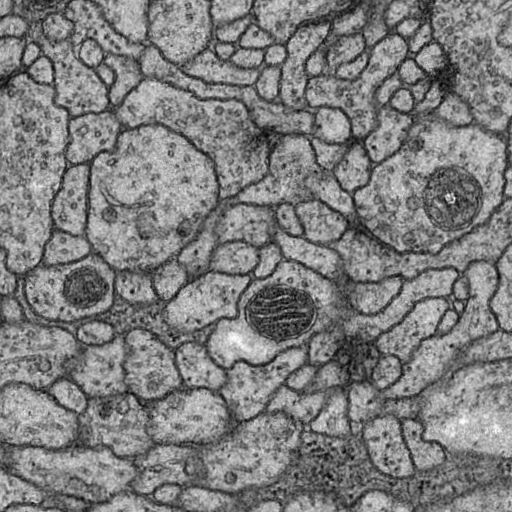

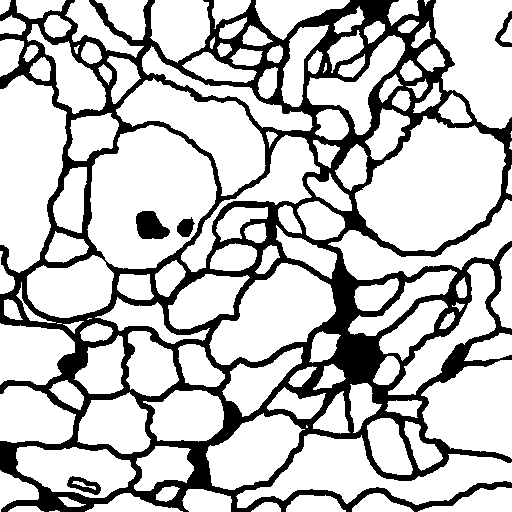

In [22]:
# dataset 준비
import os
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input
    
    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        label = label/255.0
        input = input/255.0

        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input, 'label': label}

        if self.transform:
            data = self.transform(data)

        return data

## 트렌스폼 구현하기
class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data

class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data

transformss = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])

data_set = Dataset("./unet_datasets/train", transform=transformss)
data_set_val = Dataset("./unet_datasets/val", transform=transformss)

from PIL import Image
from IPython.display import display

timg = Image.fromarray(np.load('./unet_datasets/train/input_000.npy'))
display(timg)

valimg = Image.fromarray(np.load('./unet_datasets/train/label_000.npy'))
display(valimg)

In [23]:
dataloader = torch.utils.data.DataLoader(data_set, batch_size=4, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(data_set_val, batch_size=2, shuffle=True)

In [24]:
bs=4
lr=0.001
epochs=10

unet = Unet(dim=64, mults=[1,2,4, 8], channel_scale=1).to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)
criterion = nn.BCELoss()

In [28]:
time = torch.tensor(1, device=device).unsqueeze(0).repeat(bs)
print(time.shape)

torch.Size([4])


In [29]:
from tqdm import tqdm

unet.train()
for epoch in range(epochs):
    epoch_loss = 0
    for idx, data in tqdm(enumerate(dataloader)):
        unet.zero_grad()
        
        inputs = data['input'].to(device)
        labels = data['label'].to(device)
        
        output = unet(inputs, time)

        # backward pass
        optimizer.zero_grad()

        loss = criterion(output, labels)
        loss.backward()

        optimizer.step()
        print(loss)

        epoch_loss += loss

    print(f"{epoch} Epoch - Train Loss : {epoch_loss}")

    with torch.no_grad():
        unet.eval()
        valid_loss = 0
        for idx, data in tqdm(enumerate(dataloader_val)):
            inputs = data['input'].to(device)
            labels = data['label'].to(device)
            
            output = unet(inputs, time)
    
            # backward pass
            optimizer.zero_grad()
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            valid_loss += loss
    
        print(f"{epoch} Epoch - Valid Loss : {valid_loss}")

    torch.cuda.empty_cache()

0it [00:00, ?it/s]

adw t :  torch.Size([4])
adw t_emb :  torch.Size([4, 256])
time_emb :  torch.Size([4, 256])
time_emb :  torch.Size([4, 256])
time_emb :  torch.Size([4, 256])
time_emb :  torch.Size([4, 256])
time_emb :  torch.Size([4, 256])
time_emb :  torch.Size([4, 256])
time_emb :  torch.Size([4, 256])
time_emb :  torch.Size([4, 256])
time_emb :  torch.Size([4, 256])
time_emb :  torch.Size([4, 256])


0it [00:00, ?it/s]


NameError: name 'label' is not defined